In [72]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from urllib.request import urlretrieve, urlopen
import os
import gzip
import zipfile
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [3]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words=vocab_size)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
print(X_train[:5])

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [5]:
# label 확인해보기
print(y_train[:5])

[1 0 0 1 0]


In [6]:
# 길이에 맞춰 padding
max_len = 200
X_train = pad_sequences(X_train, maxlen=200)
X_test = pad_sequences(X_test, maxlen=200)

## 1D CNN으로 IMDB 리뷰 분류하기

In [7]:
# 차곡차곡 모델 쌓아보기
model = Sequential() #순차적
model.add(Embedding(vocab_size, 256)) # 임베딩 차원 256
model.add(Dropout(0.3)) # 30% dropout
model.add(Conv1D(256, 3, padding='valid', activation='relu')) # padding x
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 256)         196864    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [9]:
# 효율적인 학습을 위한 early stopping
# val_loss가 증가하면 과적합 징후 -> 조기 종료
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [10]:
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks=[es, mc])

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.4113 - acc: 0.8012
Epoch 1: val_acc improved from -inf to 0.87960, saving model to best_model.h5
782/782 [==============================] - 84s 94ms/step - loss: 0.4113 - acc: 0.8012 - val_loss: 0.2794 - val_acc: 0.8796
Epoch 2/20
  1/782 [..............................] - ETA: 7s - loss: 0.3220 - acc: 0.8125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - ETA: 0s - loss: 0.2184 - acc: 0.9151
Epoch 2: val_acc improved from 0.87960 to 0.88888, saving model to best_model.h5
782/782 [==============================] - 18s 23ms/step - loss: 0.2184 - acc: 0.9151 - val_loss: 0.2631 - val_acc: 0.8889
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.1080 - acc: 0.9616
Epoch 3: val_acc did not improve from 0.88888
782/782 [==============================] - 13s 16ms/step - loss: 0.1080 - acc: 0.9616 - val_loss: 0.3501 - val_acc: 0.8801
Epoch 4/20
782/782 [==============================] - ETA: 0s - loss: 0.0479 - acc: 0.9848
Epoch 4: val_acc did not improve from 0.88888
782/782 [==============================] - 12s 16ms/step - loss: 0.0479 - acc: 0.9848 - val_loss: 0.3553 - val_acc: 0.8842
Epoch 5/20
782/782 [==============================] - ETA: 0s - loss: 0.0292 - acc: 0.9905
Epoch 5: val_acc did not improve from 0.88888
782/782 [==============================] - 11s 14ms/step - 

In [11]:
# model load, 정확도 평가해보기
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 3s 4ms/step - loss: 0.2631 - acc: 0.8889

 테스트 정확도: 0.8889


## 영화리뷰 분류

In [40]:
# 세부적인 parameter 설정
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [41]:
# functional api -> 입력과 출력을 모주 지정해주어야 한다.
# 입력의 크기 지정
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)

# 임베딩된 결과에 대해 0.5 drop out 수행
z = Dropout(dropout_ratio[0])(z)

In [42]:
conv_block = []
conv = 0
# drop out을 수행한 결과에 대해 수행
# 커널의 크기를 3, 4, 5로 각각 늘리기
# 패딩은 실행하지 않음, 활성화 함수: relu
# 1칸씩 이동
for sz in [3, 4, 5]:
    conv_layer = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv_layer = GlobalMaxPooling1D()(conv_layer)
    conv_block.append(conv_layer)

In [44]:
# 맥스 풀링한 결과를 concat한다.
z = Concatenate()(conv_block) if len(conv_block) > 1 else conv_block[0]

# 80% dropout 수행
z = Dropout(dropout_ratio[1])(z)

# 은닉층 노드 128개
z = Dense(hidden_units, activation="relu")(z)

# 이진 분류이므로 시그모이드
model_output = Dense(1, activation="sigmoid")(z)

# 모델 형상 지정
model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

# 4회 이상 loss가 튀면 과적합 가능성이 있으므로 stop
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10


ValueError: ignored

현재 커널의 수행을 너무 왔다갔다 해서 층이 불필요하게 추가적으로 적재됨 => 형상에 맞지 않음\
따라서 런타임 종료하고 독자적으로 실행해보기

In [ ]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

## 스팸 메일 분류

In [12]:
# 스팸 메일 data 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [16]:
# 전처리 - 필요없는 거 삭제 필요한 것만 남기기
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [17]:
# 중복 체크
print('v2열의 유니크한 값 :',data['v2'].nunique())

v2열의 유니크한 값 : 5169


In [18]:
# v2 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


<Axes: >

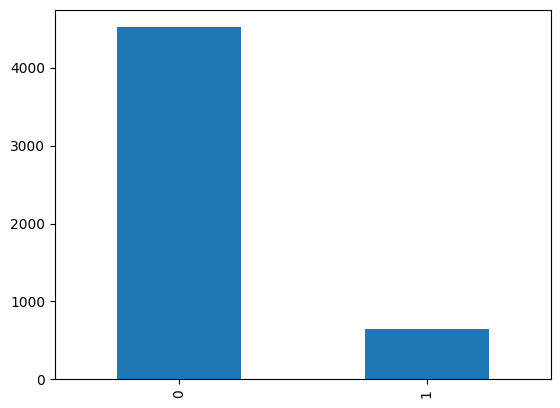

In [19]:
# 레이블 분포 확인
data['v1'].value_counts().plot(kind='bar')


-> 0이 훨씬 많음: 정상 메일이 많다

In [20]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4516
1   1    653


In [21]:
# 학습 및 test data로 지정
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [22]:
# data가 불균형(0이 압도적으로 많음) 하므로 stratify를 사용하여 레이블 분포가 고르게 하기
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # text 정수 딕셔너리 생성
X_train_encoded = tokenizer.texts_to_sequences(X_train) # text token을 정수 index화
print(X_train_encoded[:5])

[[102, 1, 210, 230, 3, 17, 39], [1, 59, 8, 427, 17, 5, 137, 2, 2326], [157, 180, 12, 13, 98, 93, 47, 9, 40, 3485, 247, 8, 7, 87, 6, 80, 1312, 5, 3486, 7, 2327, 11, 660, 306, 20, 25, 467, 708, 1028, 203, 129, 193, 800, 2328, 23, 1, 144, 71, 2, 111, 78, 43, 2, 130, 11, 800, 186, 122, 1512], [1, 1154, 13, 104, 292], [222, 622, 857, 540, 623, 22, 23, 83, 10, 47, 6, 257, 32, 6, 26, 64, 936, 407]]


In [24]:
# vocab 확인
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'on': 17, 'call': 18, 'that': 19, 'are': 20, '2': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'or': 27, "i'm": 28, 'get': 29, 'at': 30, 'do': 31, 'if': 32, 'be': 33, 'will': 34, 'just': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, '4': 42, 'how': 43, 'gt': 44, 'lt': 45, 'go': 46, 'when': 47, 'from': 48, 'what': 49, 'ok': 50, 'out': 51, 'know': 52, 'free': 53, 'all': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'am': 59, 'time': 60, 'was': 61, 'come': 62, 'its': 63, 'love': 64, 'want': 65, 'text': 66, 'he': 67, 'only': 68, 'there': 69, 'day': 70, 'need': 71, 'going': 72, 'lor': 73, 'send': 74, 'one': 75, 'as': 76, 'home': 77, 'about': 78, 'back': 79, 'still': 80, 'k': 81, 'see': 82, 'txt': 83, 'by': 84, 'da': 85, 'stop': 86, 'r': 87, 'any': 88, 'tell': 89, 'dont': 90, "i'll": 91, "don't": 9

In [25]:
# 2보다 적게 등장하는 단어가 과연 필요할까?
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.65745644331875


In [26]:
# 너무 희귀한 것은 제거하자
'''
등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면
케라스 토크나이저 선언 시에 단어 집합의 크기를 제한할 수 있습니다'''
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)

In [27]:
# padding 하기
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (4135, 189)


In [28]:
# 이전에 지정한 cnn에 학습 시키기
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.4254 - acc: 0.8694
Epoch 1: val_acc improved from 0.88888 to 0.94196, saving model to best_model.h5
52/52 [==============================] - 14s 244ms/step - loss: 0.4254 - acc: 0.8694 - val_loss: 0.1660 - val_acc: 0.9420
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 0.0847 - acc: 0.9716
Epoch 2: val_acc improved from 0.94196 to 0.96010, saving model to best_model.h5
52/52 [==============================] - 9s 177ms/step - loss: 0.0847 - acc: 0.9716 - val_loss: 0.1139 - val_acc: 0.9601
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.0280 - acc: 0.9943
Epoch 3: val_acc improved from 0.96010 to 0.96252, saving model to best_model.h5
52/52 [==============================] - 5s 99ms/step - loss: 0.0280 - acc: 0.9943 - val_loss: 0.1066 - val_acc: 0.9625
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.0114 - acc: 0.9991
Epoch 4: val_acc improved from 0.96252 to 0.96614, saving model to best_model.h5
52/52 [==============================] - 5s 100ms/step - loss: 0.0114 - acc: 0.9991 - val_loss: 0.1083 - val_acc: 0.9661
Epoch 5/10
52/52 [==============================] - ETA: 0s - loss: 0.0063 - acc: 0.9994
Epoch 5: val_acc did not improve from 0.96614
52/5

In [29]:
# 스팸메일을 잘 분류하나 확인해보기
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

33/33 [==============================] - 0s 8ms/step - loss: 0.7321 - acc: 0.8733

 테스트 정확도: 0.8733


## 사전 훈련된 워드 임베딩을 이용한 의도 분류

In [46]:
# 깃허브로부터 데이터 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_train_data.csv", filename="intent_train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_test_data.csv", filename="intent_test_data.csv")

train_data = pd.read_csv('intent_train_data.csv')
test_data = pd.read_csv('intent_test_data.csv')

In [47]:
# check data
train_data[:5]

,intent,label
0,add another song to the cita rom ntica playlist,AddToPlaylist
1,add clem burke in my playlist pre party r b jams,AddToPlaylist
2,add live from aragon ballroom to trapeo,AddToPlaylist
3,add unite and win to my night out,AddToPlaylist
4,add track to my digster future hits,AddToPlaylist


In [48]:
test_data[:5]

,intent,label
0,i 'd like to have this track onto my classical...,AddToPlaylist
1,add the album to my flow espa ol playlist,AddToPlaylist
2,add digging now to my young at heart playlist,AddToPlaylist
3,add this song by too poetic to my piano ballad...,AddToPlaylist
4,add this album to old school death metal,AddToPlaylist


In [49]:
intent_train = train_data['intent'].tolist()
label_train = train_data['label'].tolist()
intent_test = test_data['intent'].tolist()
label_test = test_data['label'].tolist()

print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


다양한 범주의 문장을 확인하고 싶다면 인덱스를 2000씩 늘려서 확인하면 된다

In [50]:
print(intent_train[2000:2002])
print(label_train[2000:2002])

print(intent_train[4000:4002])
print(label_train[4000:4002])

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian']
['BookRestaurant', 'BookRestaurant']
['what will the weather be like on feb 8 , 2034 in cedar mountain wilderness', "tell me the forecast in the same area here on robert e lee 's birthday"]
['GetWeather', 'GetWeather']


<Axes: >

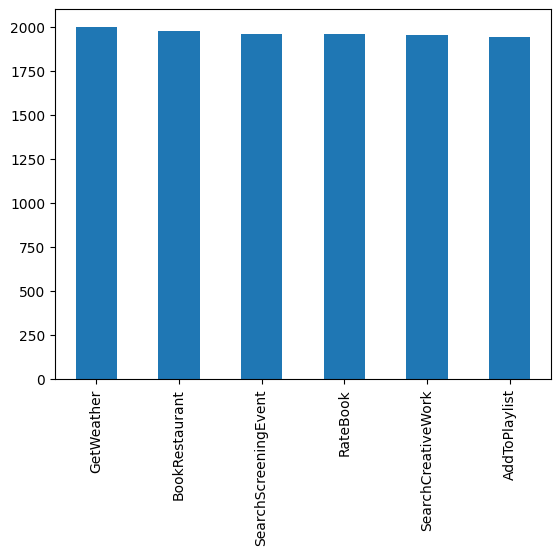

In [52]:
# 현제 데이터가 일정한 순서대로 나열되어 있기 때문에 무작위로 섞어주는 과정이 필요하다
train_data['label'].value_counts().plot(kind = 'bar')

데이터 분포도 일정

In [53]:
# 레이블 인코딩. 레이블에 고유한 정수를 부여: 0~5
# preprocessing.LabelEncoder()가 그 역할을 해줌

# 객체 호출
idx_encode = preprocessing.LabelEncoder()

# train
idx_encode.fit(label_train)

# 변환
label_train = idx_encode.transform(label_train) # 주어진 고유한 정수로 변환
label_test = idx_encode.transform(label_test) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :',label_idx)

레이블과 정수의 맵핑 관계 : {'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [54]:
# intent에도 정수 인코딩 수행: 늘 하던 과정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [55]:
# vocab 확인
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


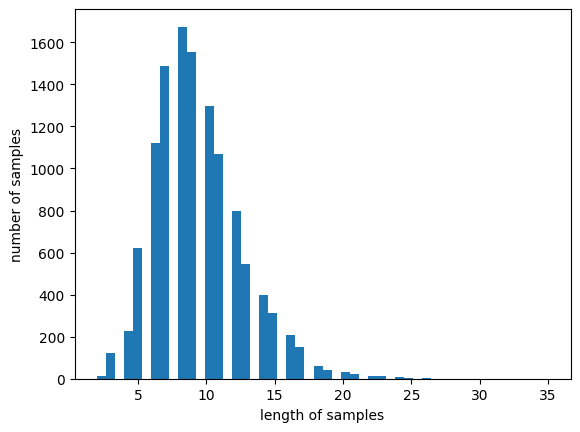

In [57]:
# 패딩을 위한 길이 확인
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [58]:
max_len = 35

intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))
print('훈련 데이터의 크기(shape):', intent_train.shape)
print('훈련 데이터 레이블의 크기(shape):', label_train.shape)

훈련 데이터의 크기(shape): (11784, 35)
훈련 데이터 레이블의 크기(shape): (11784, 6)


In [59]:
# 데이터를 뒤죽박죽 섞어주기
indices = np.arange(intent_train.shape[0]) # 0번째가 데이터 순서 ,1이 인코딩된 결과
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 3155 11515 11423 ...  5406  3084 11558]


In [60]:
# train data 지정
intent_train = intent_train[indices]
label_train = label_train[indices]

In [61]:
# valid data 지정-> 10%
n_of_val = int(0.1 * intent_train.shape[0])
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 1178


In [62]:
# 검증: 뒤에서부터 10% 추출
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test

## 1D CNN을 이용한 의도 분류

In [65]:
#사전 훈련된 GloVe 임베딩 사용
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-09-19 04:47:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-09-19 04:47:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-19 04:47:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [73]:
# 위 코드로 glove가 다운이 안됌!!!!!!!!!!!!!!!!!!!!!!
# 이 코드로 할 것
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall()
zf.close()

In [74]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [75]:
# embedding metrix의 크기 알아보기
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim)) #차원이 100이므로 열의 크기가 100
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))

임베딩 테이블의 크기(shape) : (9870, 100)


In [82]:
# 이거 하나 안했다고 정확도 난리남!
# train_data의 단어와 사전 훈련된 임베딩 값을 매핑
# 이런 정보가 있어야 당연히 수행 가능
# 이걸 없애고 수행하는 거라면 단어 간의 관계성을 하나도 유추하지 못하고 포착하지도 못함
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [83]:
kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 35, 100)              987000    ['input_7[0][0]']             
                                                                                                  
 conv1d_16 (Conv1D)          (None, 34, 512)              102912    ['embedding_2[0][0]']         
                                                                                                  
 conv1d_17 (Conv1D)          (None, 33, 512)              154112    ['embedding_2[0][0]']         
                                                                                            

In [84]:
# 모델 학습시키기
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_val, y_val))

Epoch 1/10
166/166 [==============================] - 3s 8ms/step - loss: 0.2079 - acc: 0.9359 - val_loss: 0.0629 - val_acc: 0.9796
Epoch 2/10
166/166 [==============================] - 1s 6ms/step - loss: 0.0479 - acc: 0.9866 - val_loss: 0.0421 - val_acc: 0.9839
Epoch 3/10
166/166 [==============================] - 1s 6ms/step - loss: 0.0279 - acc: 0.9932 - val_loss: 0.0404 - val_acc: 0.9864
Epoch 4/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0195 - acc: 0.9934 - val_loss: 0.0430 - val_acc: 0.9839
Epoch 5/10
166/166 [==============================] - 1s 8ms/step - loss: 0.0124 - acc: 0.9973 - val_loss: 0.0305 - val_acc: 0.9890
Epoch 6/10
166/166 [==============================] - 1s 6ms/step - loss: 0.0101 - acc: 0.9975 - val_loss: 0.0337 - val_acc: 0.9873
Epoch 7/10
166/166 [==============================] - 1s 6ms/step - loss: 0.0083 - acc: 0.9978 - val_loss: 0.0361 - val_acc: 0.9873
Epoch 8/10
166/166 [==============================] - 1s 7ms/step - loss: 0.

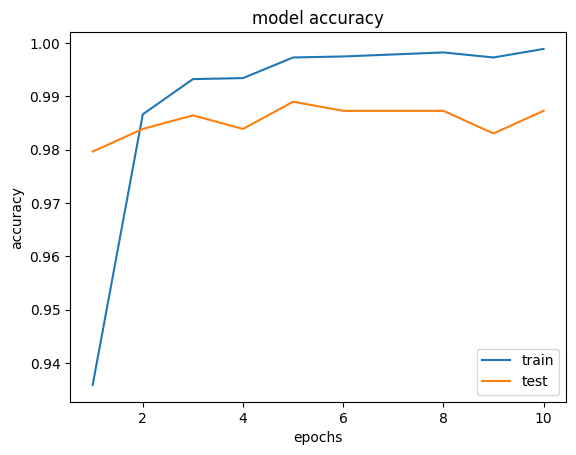

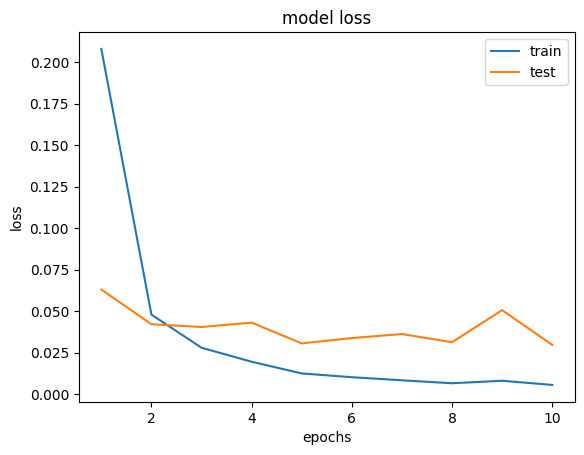

In [85]:
# 정확도 시각화하기
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# 셀 연속 두번 실행하면 오류남
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [88]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측을 정수 시퀀스로 변환

19/19 [==============================] - 0s 2ms/step


In [89]:
print('정확도(Accuracy) : ', sum(y_predicted == y_test) / len(y_test))

정확도(Accuracy) :  0.985
